# Predict diamond prices using a Deep Neural Network (Regression)

## Introductionn

A Deep Neural Network (DNN) is used to predict diamond prices. Two models were built to compare their accuracy. Features included in the dataset:

* carat
* cut
* color
* clarity
* depth
* table
* x
* y
* z

The dataset is obtained from Kaggle user [MS. NANCY AL ASWAD](https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices) and the dataset is made availaable under the [CC License](https://creativecommons.org/licenses/by/4.0/).

### Import libraries

In [144]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [145]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.1


### Data preparation and processing

In [146]:
# Examine dataset
df = pd.read_csv('/Users/Vanessa/Data_Portfolio/ML_Predict_Diamond_Prices/Diamonds_Prices_2022.csv', index_col=[0])
print(df.head())

   carat      cut color clarity  depth  table  price     x     y     z
1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
5   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75


In [147]:
print(df.shape)

(53943, 10)


In [148]:
print(df.dtypes)

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object


In [149]:
# Clean the data and check for null values
df.isna().sum().sum()

0

Since there are no null values in the dataset, will proceed.

The following columns are categorical, not numeric:

* cut
* color
* clarity

The next step is to one-hot encode the values in the column with pd.get_dummies.

In [150]:
df = pd.get_dummies(df, columns = ['cut','color','clarity'])
print(df.tail())

       carat  depth  table  price     x     y     z  cut_Fair  cut_Good  \
53939   0.86   61.0   58.0   2757  6.15  6.12  3.74         0         0   
53940   0.75   62.2   55.0   2757  5.83  5.87  3.64         0         0   
53941   0.71   60.5   55.0   2756  5.79  5.74  3.49         0         0   
53942   0.71   59.8   62.0   2756  5.74  5.73  3.43         0         0   
53943   0.70   60.5   59.0   2757  5.71  5.76  3.47         0         0   

       cut_Ideal  ...  color_I  color_J  clarity_I1  clarity_IF  clarity_SI1  \
53939          0  ...        0        0           0           0            0   
53940          1  ...        0        0           0           0            0   
53941          0  ...        0        0           0           0            1   
53942          0  ...        0        0           0           0            1   
53943          0  ...        0        0           0           0            0   

       clarity_SI2  clarity_VS1  clarity_VS2  clarity_VVS1  clarity_

Before preparing the training and test data sets, I have previously encountered errors when normalizing features of dtype float64. Therefore, I will first convert all float64 to float32.

In [151]:
# Convert columns with float64 to float32 
df[df.select_dtypes(np.float64).columns] = df.select_dtypes(np.float64).astype(np.float32)
# Check that the columns are converted
print(df.dtypes)

carat            float32
depth            float32
table            float32
price              int64
x                float32
y                float32
z                float32
cut_Fair           uint8
cut_Good           uint8
cut_Ideal          uint8
cut_Premium        uint8
cut_Very Good      uint8
color_D            uint8
color_E            uint8
color_F            uint8
color_G            uint8
color_H            uint8
color_I            uint8
color_J            uint8
clarity_I1         uint8
clarity_IF         uint8
clarity_SI1        uint8
clarity_SI2        uint8
clarity_VS1        uint8
clarity_VS2        uint8
clarity_VVS1       uint8
clarity_VVS2       uint8
dtype: object


### Exploring the dataset and extracting relevant features for DNN

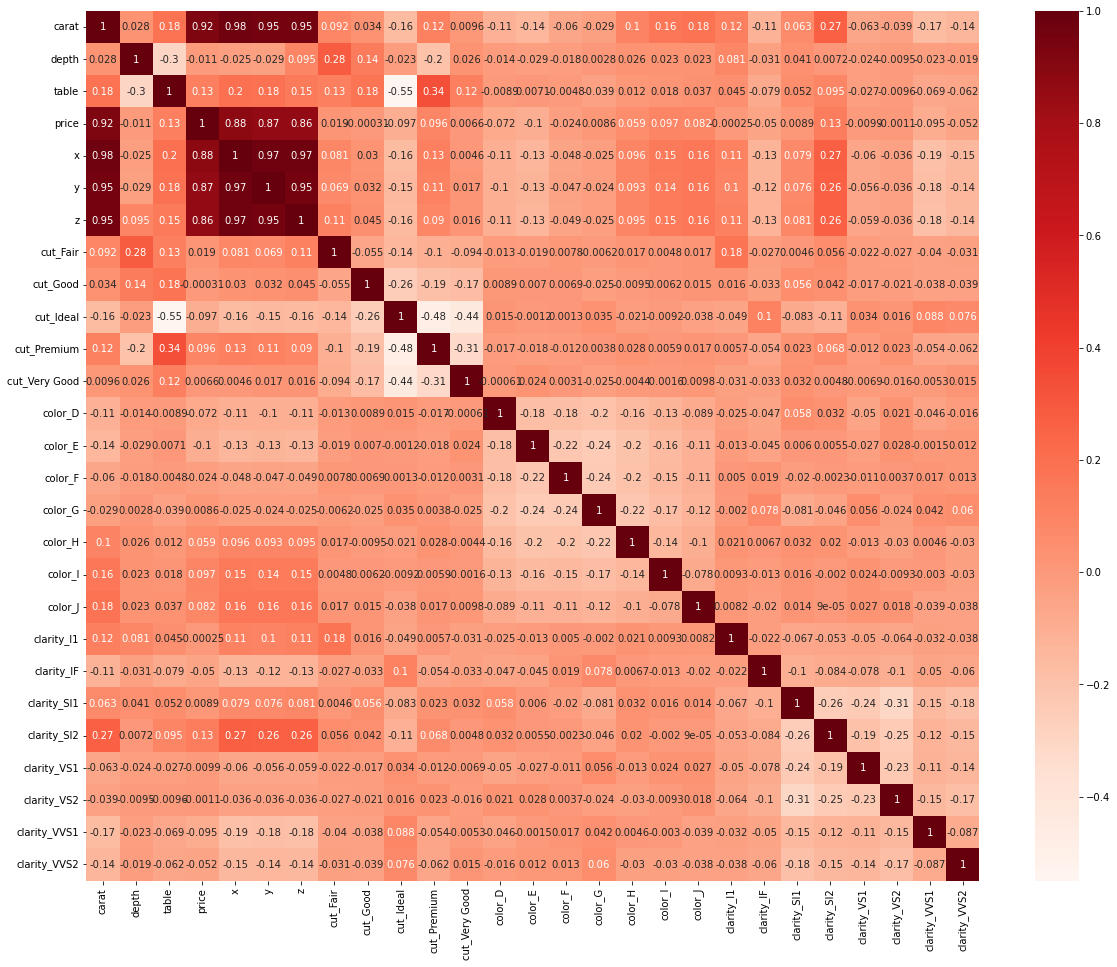

In [152]:
# Perform pearson's correlation coefficient to see how each variable correlate with price
plt.figure(figsize=(20,16))
corr_coef = df.corr()
sns.heatmap(corr_coef, annot=True, cmap=plt.cm.Reds)
plt.show()

   price  carat     x     y     z
1    326   0.23  3.95  3.98  2.43
2    326   0.21  3.89  3.84  2.31
3    327   0.23  4.05  4.07  2.31
4    334   0.29  4.20  4.23  2.63
5    335   0.31  4.34  4.35  2.75


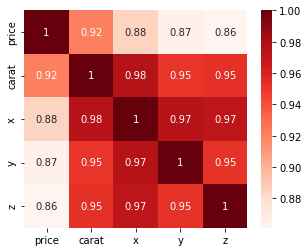

In [153]:
df2 = df[['price','carat','x','y','z']]
print(df2.head())
plt.figure(figsize=(5,4))
corr_coef = df2.corr()
sns.heatmap(corr_coef, annot=True, cmap=plt.cm.Reds)
plt.show()

### Preparing training and test datasets

In [154]:
# Split the dataset into training and test sets
train_dataset = df2.sample(frac=0.8, random_state=0)
test_dataset = df2.drop(train_dataset.index)

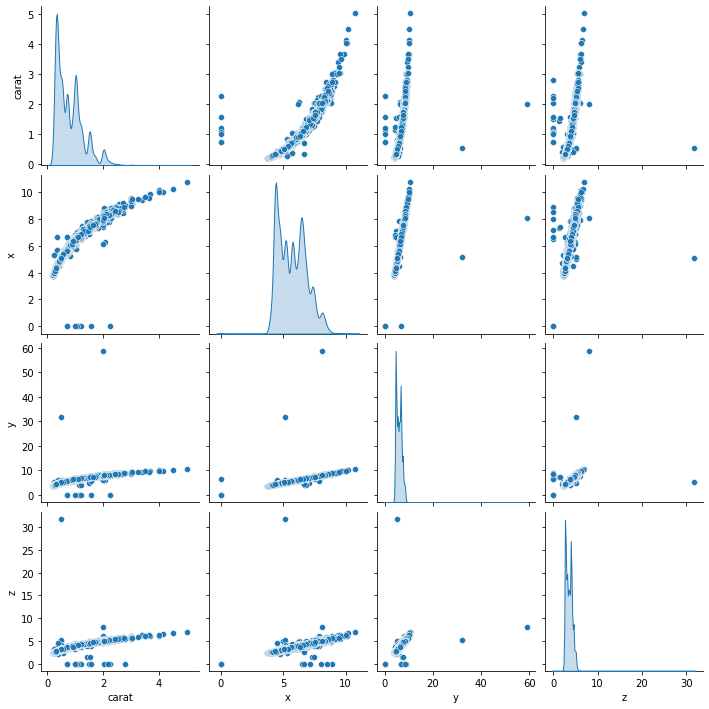

In [155]:
# Inspect the data
sns.pairplot(train_dataset[['carat', 'x', 'y', 'z']], diag_kind='kde')
plt.show()

In [156]:
# Check the overall statistics
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,43154.0,3929.621263,3989.616808,326.0,947.25,2400.00,5315.00,18818.000000
carat,43154.0,0.797087,0.473767,0.2,0.40,0.70,1.04,5.010000
x,43154.0,5.728662,1.122400,0.0,4.71,5.69,6.54,10.740000
y,43154.0,5.732543,1.149680,0.0,4.72,5.71,6.53,58.900002
z,43154.0,3.537700,0.708456,0.0,2.91,3.52,4.03,31.799999


In [157]:
# Split features from labels
# Separate the target value "price" from the features
# "Price" is the value that the model is trained to predict

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('price')
test_labels = test_features.pop('price')


### Feature normalization

In [158]:
# Normalization of features that use different scales and ranges makes training more stable
normalizer = tf.keras.layers.Normalization(axis=-1)
# Fit the state of the preprocessing layer to the data
normalizer.adapt(np.array(train_features))
# Calculate the mean and variance, and store them in the layer
print(normalizer.mean.numpy())

[[0.79708314 5.728672   5.732551   3.5377085 ]]


### Preparing the model and visualization 

In [159]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [price]')
  plt.legend()
  plt.grid(True)

In [160]:
# Regression using a DNN and selected inputs

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 4)                9         
 ion)                                                            
                                                                 
 dense_36 (Dense)            (None, 128)               640       
                                                                 
 dense_37 (Dense)            (None, 128)               16512     
                                                                 
 dense_38 (Dense)            (None, 64)                8256      
                                                                 
 dense_39 (Dense)            (None, 1)                 65        
                                                                 
Total params: 25,482
Trainable params: 25,473
Non-trainable params: 9
__________________________________________________

### Fit model on training data

In [161]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 2min 50s, sys: 42.3 s, total: 3min 33s
Wall time: 1min 55s


To evaluate the model, the training metrics for each epoch is plotted, and the accuracy of the model reaches a pleateau after ~10th epoch.

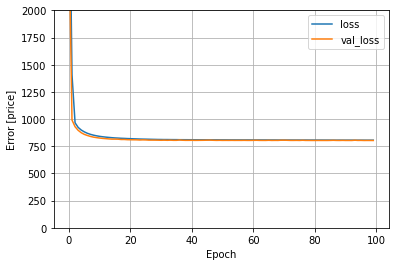

In [162]:
plot_loss(history)

### Evaluate the model

The mean absolute error (MAE) refers to the mean difference between predicted and actual value, in this case, price of diamond. Ideally, the lower the number, the more accurate the model. However, the price range of diamonds, which goes from 326 to 18818, should also be taken into consideration. 

In [163]:
MAE = dnn_model.evaluate(test_features, test_labels, verbose=0)
test_results = {}
test_results['feature_extraction_MA'] = MAE
print('Mean absolute error:', round(MAE,2))

Mean absolute error: 805.18


338/338 [==============================] - 0s 662us/step


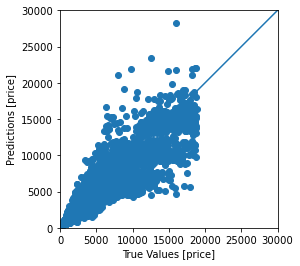

In [164]:
# Predict with the dnn_model on the test set using Keras Model.predict and review the loss

test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [price]')
plt.ylabel('Predictions [price]')
lims = [0, 30000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [165]:
from sklearn.metrics import r2_score

r2score = r2_score(test_labels,test_predictions)
test_results['feature_extraction_r2score'] = r2score
print('Model accuracy (R2):', round(r2score,2))

Model accuracy (R2): 0.86


### Reflection

Since the MAE is rather high, I would now include all features and see if it would improve the accuracy of the model.

### Including all features  for the DNN

In [166]:
# Split the dataset into training and test sets
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [167]:
# Check the overall statistics
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
carat,43154.0,0.797087,0.473767,0.2,0.40,0.700000,1.04,5.010000
depth,43154.0,61.748489,1.432717,43.0,61.00,61.799999,62.50,79.000000
table,43154.0,57.456493,2.239814,44.0,56.00,57.000000,59.00,95.000000
price,43154.0,3929.621263,3989.616808,326.0,947.25,2400.000000,5315.00,18818.000000
x,43154.0,5.728662,1.122400,0.0,4.71,5.690000,6.54,10.740000
y,43154.0,5.732543,1.149680,0.0,4.72,5.710000,6.53,58.900002
z,43154.0,3.537700,0.708456,0.0,2.91,3.520000,4.03,31.799999
cut_Fair,43154.0,0.029638,0.169589,0.0,0.00,0.000000,0.00,1.000000
cut_Good,43154.0,0.090235,0.286521,0.0,0.00,0.000000,0.00,1.000000
cut_Ideal,43154.0,0.400983,0.490103,0.0,0.00,0.000000,1.00,1.000000


In [168]:
# Split features from labels
# Separate the target value "price" from the features
# "Price" is the value that the model is trained to predict

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('price')
test_labels = test_features.pop('price')


In [169]:
# Normalization of features that use different scales and ranges makes training more stable
normalizer = tf.keras.layers.Normalization(axis=-1)
# Fit the state of the preprocessing layer to the data
normalizer.adapt(np.array(train_features))
# Calculate the mean and variance, and store them in the layer
print(normalizer.mean.numpy())

[[7.9708314e-01 6.1748421e+01 5.7456383e+01 5.7286720e+00 5.7325511e+00
  3.5377085e+00 2.9638048e-02 9.0234980e-02 4.0098205e-01 2.5473905e-01
  2.2440539e-01 1.2573557e-01 1.8109535e-01 1.7525615e-01 2.1001521e-01
  1.5463206e-01 9.9689484e-02 5.3575639e-02 1.3579283e-02 3.3878662e-02
  2.4178499e-01 1.6899918e-01 1.5159670e-01 2.2753370e-01 6.8220749e-02
  9.4406083e-02]]


In [170]:
# Regression using a DNN with all inputs

dnn_model_all = build_and_compile_model(normalizer)
dnn_model_all.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normalizat  (None, 26)               53        
 ion)                                                            
                                                                 
 dense_40 (Dense)            (None, 128)               3456      
                                                                 
 dense_41 (Dense)            (None, 128)               16512     
                                                                 
 dense_42 (Dense)            (None, 64)                8256      
                                                                 
 dense_43 (Dense)            (None, 1)                 65        
                                                                 
Total params: 28,342
Trainable params: 28,289
Non-trainable params: 53
________________________________________________

In [171]:
%%time
history = dnn_model_all.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3min, sys: 45.6 s, total: 3min 46s
Wall time: 2min 3s


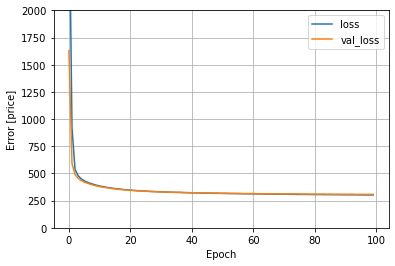

In [172]:
plot_loss(history)

In [173]:
MAE = dnn_model_all.evaluate(test_features, test_labels, verbose=0)
test_results['feature_all_MAE'] = MAE
print('Mean absolute error:', round(MAE,2))

Mean absolute error: 310.86


338/338 [==============================] - 0s 635us/step


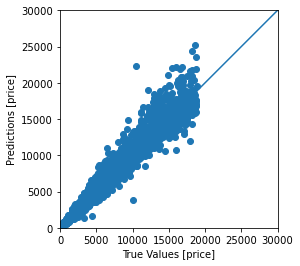

In [174]:
# Predict with the dnn_model on the test set using Keras Model.predict and review the loss

test_predictions = dnn_model_all.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [price]')
plt.ylabel('Predictions [price]')
lims = [0, 30000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [175]:
from sklearn.metrics import r2_score

r2score = r2_score(test_labels,test_predictions)
test_results['feature_all_r2score'] = r2score
print('Model accuracy (R2):', round(r2score,2))

Model accuracy (R2): 0.97


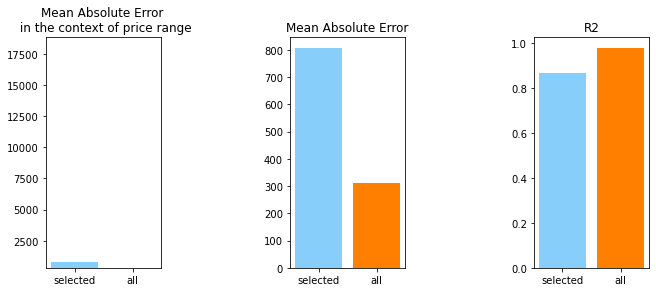

In [241]:
fig = plt.figure(figsize=(12,4))
df_plot = pd.DataFrame(test_results, index=['metrics']).T
ax1 = fig.add_subplot(131, box_aspect = 2)
x = [1, 2]
y = [df_plot['metrics'][0], df_plot['metrics'][2]]
plt.bar(x, y, color = ['#87CEFA', '#FF7F00'])
plt.xticks(ticks=[1,2],labels=['selected','all'])
plt.ylim(df['price'].min(),df['price'].max()) #MAE in the context of price range
plt.title('Mean Absolute Error \n in the context of price range')
ax2 = fig.add_subplot(132, box_aspect = 2)
x = [1, 2]
y = [df_plot['metrics'][0], df_plot['metrics'][2]]
plt.bar(x, y, color = ['#87CEFA', '#FF7F00'])
plt.xticks(ticks=[1,2],labels=['selected','all'])
plt.title('Mean Absolute Error')
ax3 = fig.add_subplot(133, box_aspect = 2)
x = [1, 2]
y = [df_plot['metrics'][1], df_plot['metrics'][3]]
plt.bar(x, y, color = ['#87CEFA', '#FF7F00'])
plt.xticks(ticks=[1,2],labels=['selected','all'])
plt.title('R2')
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)
plt.show()

## Conclusion

The accuracy of DNN trained with all features is much higher, and the MAE is much lower, when compared to extracting features that are highly correlated with the prediction variable (in this case, price). Since this is a rather small dataset, it is not too computationally-heavy and time-consuming to train with all features. 

### Resources

* Adapted from [Basic regression: Predict fuel efficiency](https://www.tensorflow.org/tutorials/keras/regression) on TensorFlow

Other reading materials:
* [Display Deep Learning Model Training History in Keras](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)
* [Train and evaluate models](https://www.tensorflow.org/guide/keras/train_and_evaluate)
* [Feature Selection with sklearn and Pandas](https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b)